# Question 1

In [351]:
# Imports
import PIL
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd

In [352]:
# Reshaping, flattening images and separating the color channels
imgs = os.listdir("afhq_dog/")
img_dir = "afhq_dog/"

flattened = []
for img in imgs:
    resized_img = PIL.Image.open("{}{}".format(img_dir, img)).resize((64,64), Image.BILINEAR) # Resizing to 64x64
    flattened.append(np.array(resized_img).astype('int').flatten().reshape(4096, 3)) # Flattening images

X = np.array(flattened) # Stacking and getting array of 5239 * 4096 *3

red_channel = X[:,:, 0] # Slicing to obtain each color channel
green_channel = X[:,:, 1]
blue_channel = X[:,:, 2]

In [353]:
def pca(Xi, ks, output): # It will take each channel at once and will find pca of it
    Xi_mean = np.mean(Xi, axis = 0) # Xmean
    Xi_minus_mean = Xi - Xi_mean # Subtracting mean
    
    covariance_matrix = np.cov(Xi_minus_mean.T) # Finding Cov(X,X)
    
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix) # Finding eigenvalues and vectors
    eigenvectors = eigenvectors.T # Taking transpose to have row matrix
    
    sorted_indices = np.argsort(eigenvalues)[::-1] # Sorting in descending order
    
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[sorted_indices]
    
    kpc_arr = []
    reduced_arr = []
    reconstructed_arr = []
    
    for k in ks:
        k_principal_components = eigenvectors[0:k] # First 19 needed for 70% PVE
        k_eigenvalues = eigenvalues[0:k]
        reduced_Xi = np.dot(Xi_minus_mean, k_principal_components.T)
        reconstructed_Xi = np.dot(reduced_Xi, k_principal_components) + Xi_mean
        
        kpc_arr.append(k_principal_components)
        reduced_arr.append(reduced_Xi)
        reconstructed_arr.append(reconstructed_Xi)
        
        if output:
            print("PVE of {} Principal Vectors: ".format(k), k_eigenvalues/np.sum(eigenvalues))
            print("Total PVE of {} Principal Vectors: ".format(k), np.sum(k_eigenvalues/np.sum(eigenvalues)))
            
    return kpc_arr, reduced_arr, reconstructed_arr

In [363]:
# Q1.1
ks = [10] # Finding pca, projection, and reconstruction for first 10 PCA
red_channel_pca, projection_red, reconstructed_red = pca(red_channel, ks, True)
green_channel_pca, projection_blue, reconstructed_green = pca(green_channel, ks, True)
blue_channel_pca, projection_green, reconstructed_blue = pca(blue_channel, ks, True)

PVE of 10 Principal Vectors:  [0.21506811 0.13542096 0.07504082 0.05172646 0.0422859  0.02458043
 0.02177032 0.01989657 0.01706975 0.01655849]
Total PVE of 10 Principal Vectors:  0.6194178151855934
PVE of 10 Principal Vectors:  [0.20045373 0.13767588 0.07695188 0.05396965 0.04291814 0.02602156
 0.02142609 0.02081249 0.0173932  0.01681111]
Total PVE of 10 Principal Vectors:  0.6144337490672251
PVE of 10 Principal Vectors:  [0.22994562 0.1367701  0.07033232 0.05355895 0.0398173  0.02373058
 0.02098965 0.02075654 0.01668027 0.01629147]
Total PVE of 10 Principal Vectors:  0.6288728015916357


In [395]:
# Q1.2
reshaped_red_channel_pca = red_channel_pca[0].reshape(10, 64,64)
reshaped_green_channel_pca = green_channel_pca[0].reshape(10, 64,64)
reshaped_blue_channel_pca = blue_channel_pca[0].reshape(10, 64,64)

# Reshaping and scaling
scaled_red_channel_pca = ((reshaped_red_channel_pca - np.min(reshaped_red_channel_pca))
                          /(np.max(reshaped_red_channel_pca) - np.min(reshaped_red_channel_pca)))

scaled_green_channel_pca = ((reshaped_green_channel_pca - np.min(reshaped_green_channel_pca))
                          /(np.max(reshaped_green_channel_pca) - np.min(reshaped_green_channel_pca)))

scaled_blue_channel_pca = ((reshaped_blue_channel_pca - np.min(reshaped_blue_channel_pca))
                          /(np.max(reshaped_blue_channel_pca) - np.min(reshaped_blue_channel_pca)))

In [396]:
# Stacking to obtain RGB images
rgb_stacked = np.stack((scaled_red_channel_pca, scaled_green_channel_pca, scaled_blue_channel_pca), axis=-1) 

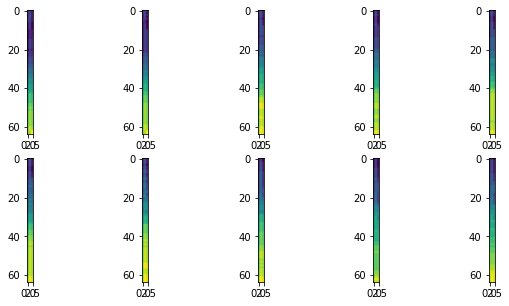

In [494]:
# Visualizing first 10 PCA
fig = plt.figure(figsize=(10, 5))
cols = 5
rows = 2
for i in range(0, 10):
    eigenvalue_img = rgb_stacked[i]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(eigenvalue_img)
plt.show()

In [398]:
# Q1.3
k_values = [1, 50, 250, 500, 1000, 4096]

# Reconstructing for 6 different k values
red_channel_pca, projection_red, reconstructed_red = pca(red_channel, k_values, False) 
green_channel_pca, projection_blue, reconstructed_green = pca(green_channel, k_values, False)
blue_channel_pca, projection_green, reconstructed_blue = pca(blue_channel, k_values, False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


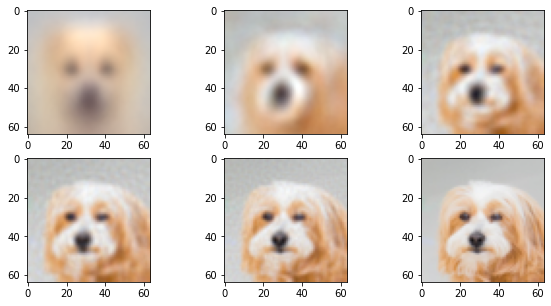

In [400]:
# Visualizing the reconstructed images
fig = plt.figure(figsize=(10, 5))
cols = 3
rows = 2
for i in range(0, 6):
    rgb_stacked = np.stack((reconstructed_red[i][0], reconstructed_green[i][0], reconstructed_blue[i][0]), axis=-1).reshape(64,64,3)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(rgb_stacked.astype('int'))

plt.show()

# Question 2

In [532]:
# Handling dataset: open, split
grid_data = pd.read_csv('dataset.csv')
grid_data_arr = np.array(grid_data, dtype=np.longdouble)

np.random.shuffle(grid_data_arr)

grid_data_x = grid_data_arr[:,:-1]
grid_data_y = grid_data_arr[:, -1]

no_of_instances = len(grid_data_arr)

test_validation_size = int(no_of_instances * 0.3)
train_size = no_of_instances - test_validation_size

validation_size = int(test_validation_size * 1/3)
test_size = test_validation_size - validation_size

train_x = grid_data_x[:train_size]
train_y = grid_data_y[:train_size]

validation_x = grid_data_x[train_size:train_size + validation_size]
validation_y = grid_data_y[train_size:train_size + validation_size]

test_x = grid_data_x[train_size + validation_size:]
test_y = grid_data_y[train_size + validation_size:]

print(len(train_x), len(validation_x), len(test_x))

42000 6000 12000


In [535]:
# Normalizing the data
mins = []
maxs = []
for i in range(train_x.shape[1]):
    maxs.append(train_x[:, i].max())
    mins.append(train_x[:, i].min())

for i in range(train_x.shape[1]):
    train_x[:, i] = (train_x[:, i] - mins[i]) / (maxs[i] - mins[i])
    validation_x[:, i] = (validation_x[:, i] - mins[i]) / (maxs[i] - mins[i])
    test_x[:, i] = (test_x[:, i] - mins[i]) / (maxs[i] - mins[i])



array([[0.46383614, 0.60990764, 0.28397209, ..., 0.46549786, 0.49549242,
        0.83702936],
       [0.8445521 , 0.36479766, 0.93418708, ..., 0.85776536, 0.01148542,
        0.511682  ],
       [0.27360343, 0.56857485, 0.1192527 , ..., 0.06516259, 0.07433541,
        0.69722917],
       ...,
       [0.89318797, 0.25660846, 0.22262457, ..., 0.10106178, 0.62980442,
        0.55160619],
       [0.53172639, 0.30420677, 0.6689724 , ..., 0.68889152, 0.52716024,
        0.94002398],
       [0.52485139, 0.85011643, 0.72142555, ..., 0.5184189 , 0.28810481,
        0.79011175]], dtype=float64)

In [536]:
def logistic_with_full_batch(x_train, x_test, y_train, alpha):
    
    def py0(x, w):
        return 1/(1 + np.exp(np.dot(x,w)))

    def py1(x, w):
        return (np.exp(np.dot(x,w))) / (1 + np.exp(np.dot(x,w)))

    def update_weight(w, x, y, a):
        total = np.zeros(w.shape)
        for j in range(len(x)):
            total += x[j] * (y[j] - py1(x[j], w))
            
        return w + a * total
    
    def fit(x, y, a):
        w = np.random.normal(loc=0, scale=1, size=12)
        for epoch in range(100):
            w = update_weight(w, x, y, a)
        return w
    
    def transform(x, w):
        predictions = []
        
        for sample in x:
            predictions.append(np.argmax([py0(x, w), py1(x, w)]))
        return predictions
    
    w_trained = fit(x_train, y_train, alpha)
    return transform(x_test, w_trained)

In [ ]:
predictions = logistic_with_full_batch(train_x, test_x, train_y, 0.05)

<ipython-input-536-baa80d2b9e3b>:7: RuntimeWarning: overflow encountered in exp
  return (np.exp(np.dot(x,w))) / (1 + np.exp(np.dot(x,w)))
<ipython-input-536-baa80d2b9e3b>:7: RuntimeWarning: invalid value encountered in double_scalars
  return (np.exp(np.dot(x,w))) / (1 + np.exp(np.dot(x,w)))


In [ ]:
predictions

In [ ]:
# Performance Metrics